In this notebook we will use the nn class **Sequential** to model a CNN

We will use the single target network

# Import

In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import KFold

from tqdm import tqdm

import load_script
from params import *
from custom_layers import *
from training import *

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading the dataset

In [42]:
train_dataset,train_target=load_script.load_dataset_1000hz(train=True)

In [43]:
test_dataset,test_target=load_script.load_dataset_1000hz(train=False)

In [41]:
train_dataset,train_target=load_script.load_dataset(train=True)

In [33]:
test_dataset,test_target=load_script.load_dataset(train=False)

# Normalization

In [44]:
mean=train_dataset.mean(0).mean(1).view(1,28,1)
std=train_dataset.std(2).mean(0).view(1,28,1)

In [45]:
train_dataset=(train_dataset-mean)/std
test_dataset=(test_dataset-mean)/std

In [ ]:
# Smoothing

data = train_dataset.data.numpy()

if 1:
    for j, sample in enumerate(data):
        for i, s in enumerate(sample):
            for k, value in enumerate(s):
                if k > 1 and k < (len(s) - 2):
                    data[j,i,k] = np.mean(s[(k-2):(k+2)])
            data[j,i,1] = np.mean(data[j,i,0:3])
            data[j,i,-2] = np.mean(data[j,i,-3:])

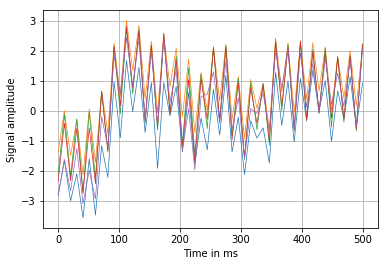

In [46]:
for i in range(5):
    plt.plot(np.linspace(0, 500, 50), train_dataset.data.numpy()[0,i,:], linewidth=0.7)
plt.grid()
plt.xlabel("Time in ms")
plt.ylabel("Signal amplitude")
plt.savefig("signal_sample_3.eps", format='eps')

# Add noise

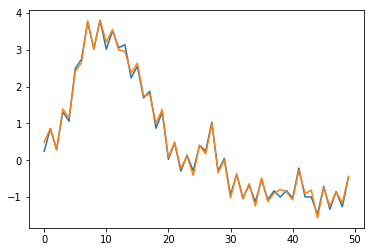

In [8]:
data = train_dataset.data.numpy()

train_ds = []
train_ds.append(data)
for i in range(4):
    train_ds.append(data + np.random.normal(scale = 0.1, size = data.shape))

A = np.asarray(train_ds).reshape(316 * 5, 28, 50)

plt.plot(A[4,1,:])
plt.plot(A[316 * 2 + 4,1,:])

train_dataset = Variable(torch.FloatTensor(A))
train_target = Variable(torch.LongTensor(np.tile(train_target.data.numpy().T, 5).T)) #Repeat target values

# Ridge regression

In [ ]:
train_reg = train_dataset.data.numpy().mean(1)
train_reg_std = train_dataset.data.numpy().mean(1).std(1)
test_reg = test_dataset.data.numpy().mean(1)
test_reg_std = test_dataset.data.numpy().mean(1).std(1)


In [ ]:
train_reg = data.mean(1)

Fourier transform

In [ ]:
from scipy.fftpack import rfft

train_reg = rfft(train_reg)[:,:]
test_reg = rfft(test_reg)[:,:]

In [ ]:
plt.plot((train_reg[7,:]))

In [ ]:
from sklearn import linear_model

reg = linear_model.Ridge (alpha = 1)
reg.fit (train_reg, train_target.data.numpy()) 

In [ ]:
train_prediction = train_reg.dot(reg.coef_)  + reg.intercept_

sum(train_prediction.round() == train_target.data.numpy()) / 316 /5

In [ ]:
test_prediction = test_reg.dot(reg.coef_)  + reg.intercept_

sum(test_prediction.round() == test_target.data.numpy())

In [ ]:
logistic = linear_model.LogisticRegression()
logistic.fit(train_reg, train_target.data.numpy())

In [ ]:
logistic.score(train_reg, train_target.data.numpy())

In [ ]:
logistic.score(test_reg, test_target.data.numpy())

# Defining the network

### Simple Network

In [10]:
class ThreeLayers2D(nn.Module):
    
    num_my_conv_layers=2
    num_linear_layers=3
    
    def __init__(self,params):
        super(ThreeLayers2D,self).__init__()
        
        self.params=params
        
        layers=[]
        layers.append(Tensor4D())
        for i in range(self.num_my_conv_layers): 
            layers+=MyConv2D(*self.params[i]).layers
        layers.append(Flatten())
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers]))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers+1]))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers+2]))
        layers.append(nn.Sigmoid())
        
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x
    

In [70]:
class ThreeLayers(nn.Module):
    
    num_my_conv_layers=3
    num_linear_layers=3
    
    def __init__(self,params):
        super(ThreeLayers,self).__init__()
        
        self.params=params
        
        layers=[]
        for i in range(self.num_my_conv_layers): 
            layers+=MyConv1D(*self.params[i]).layers
        
        layers.append(Flatten())
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers]))
        layers.append(nn.BatchNorm1d(self.params[self.num_my_conv_layers][1]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.6))
        
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers+1]))   
        layers.append(nn.BatchNorm1d(self.params[self.num_my_conv_layers+1][1]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0))
        
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers+2]))
        #layers.append(nn.BatchNorm1d(self.params[self.num_my_conv_layers+2][1]))
        
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x

# Training

In [ ]:
# Test stabile sul 79, con early stopping

cv=CrossValidation(k=2,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target)

net_type=ThreeLayers
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(conv_filters=[28,20,10],conv_kernels=[5,3,3],
                             linear_filters=[150, 20, 2],
                             dropout_rate=0.8, batch_norm=True, conv1D=True)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=200, mini_batch_size=79*2)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,)

cv(params)


  0%|          | 0/200 [00:00<?, ?it/s]

Network:

[28, 28, 5, 0.8, True]
[28, 20, 3, 0.8, True]
[20, 10, 3, 0.8, True]
[420, 150]
[150, 20]
[20, 2]

Repetition 0



 98%|█████████▊| 195/200 [01:08<00:01,  2.84it/s]

In [ ]:
cv=CrossValidation(k=2,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target)

net_type=ThreeLayers2D
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(conv_filters=[5, 10],conv_kernels=[(1,3), (28,5)],
                             linear_filters=[100, 50, 2],
                             dropout_rate=0.5, batch_norm=True, conv1D=False)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=40, mini_batch_size=79)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,)

cv(params)

In [ ]:
cv=CrossValidation(k=2,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target)

net_type=ThreeLayers
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(conv_filters=[10,10,10],conv_kernels=[3, 3, 3],
                             linear_filters=[100, 50, 2],
                             dropout_rate=0.7, batch_norm=True, conv1D=True)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=200, mini_batch_size=79)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,)

cv(params)

In [ ]:
cv=CrossValidation(k=2,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target)

net_type=ThreeLayers2D
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(conv_filters=[28,28,28],conv_kernels=[(3,1),(5,3),(3,3)],
                             linear_filters=[200,2],
                             dropout_rate=0,batch_norm=False,conv1D=False)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=100,mini_batch_size=79)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,)

cv(params)

In [ ]:
net_type=ThreeLayers
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(linear_filters=[200,2],dropout_rate=0)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=100)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,)

train=Train(train_dataset=train_dataset,test_dataset=test_dataset,
            train_target=train_target,test_target=test_target)
train(params)